In [12]:
import math
import torch
from torch import nn

#活性化関数Swish

生の入力　×　Sigmoid(x)

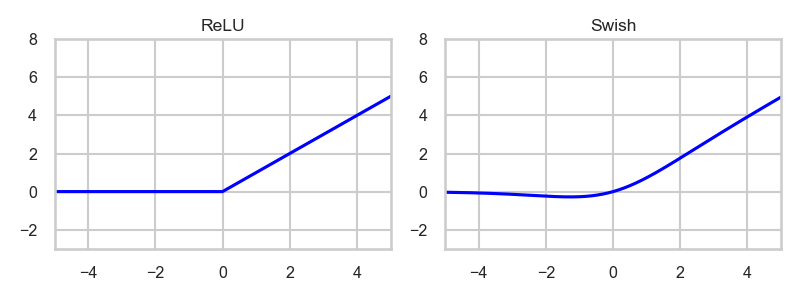

# Model

In [13]:
class Swish(nn.Module):
  def forward(self, x):
    return x * torch.sigmoid(x)

In [14]:
class SEblock(nn.Module):
  def __init__(self, ch_in, ch_sq):
    super().__init__()
    self.se = nn.Sequential(
        nn.AdaptiveAvgPool2d(1),
        nn.Conv2d(ch_in, ch_sq, 1),
        Swish(),
        nn.Conv2d(ch_sq, ch_in, 1),
    )
    self.se.apply(weight_init)

  def forward(self, x):
    return x * torch.sigmoid(self.se(x))

def weight_init(m):
  if isinstance(m, nn.Conv2d):
    nn.init.kaiming_normal_(m.weight)

  if isinstance(m, nn.Linear):
    nn.init.kaiming_uniform_(m.weight)
    nn.init.zeros_(m.bias)

In [15]:
class ConvBN(nn.Module):
  def __init__(self, ch_in, ch_out, kernel_size, stride=1, padding=0, groups=1):
    super().__init__()
    self.layers=nn.Sequential(
        nn.Conv2d(ch_in, ch_out, kernel_size, stride, padding, groups=groups, bias=False),
        nn.BatchNorm2d(ch_out),
    )
    self.layers.apply(weight_init)

  def forward(self, x):
    return self.layers(x)

In [16]:
class DropConnect(nn.Module):
  def __init__(self, drop_rate):
    super().__init__()
    self.drop_rate=drop_rate

  def forward(self, x):
    if self.training:
      keep_rate=1.0-self.drop_rate
      r = torch.rand([x.size(0),1,1,1], dtype=x.dtype).to(x.device)
      r+=keep_rate
      mask=r.floor()
      return x.div(keep_rate)*mask
    else:
      return x

In [17]:
class BMConvBlock(nn.Module):
  def __init__(self,ch_in,ch_out,expand_ratio,stride,kernel_size,reduction_ratio=4,drop_connect_rate=0.2):
    super().__init__()
    self.use_residual = (ch_in==ch_out) & (stride==1)
    ch_med = int(ch_in*expand_ratio)
    ch_sq  = max(1, ch_in//reduction_ratio)

    if expand_ratio != 1.0:
      layers = [ConvBN(ch_in, ch_med, 1), Swish()]
    else:
      layers = []
    
    layers.extend([ConvBN(ch_med, ch_med, kernel_size, stride=stride, padding=(kernel_size)//2, groups=ch_med),
                  Swish(),
                  SEblock(ch_med, ch_sq),
                  ConvBN(ch_med, ch_out, 1),
                  ])
    
    if self.use_residual:
      self.drop_connect = DropConnect(drop_connect_rate)

    self.layers = nn.Sequential(*layers)

  def forward(self, x):
    if self.use_residual:
      return x + self.drop_connect(self.layers(x))
    else:
      return self.layers(x)

In [18]:
class Flatten(nn.Module):
  def forward(self, x):
    return x.view(x.shape[0], -1)

In [19]:
class EfficientNet(nn.Module):
  def __init__(self,
               width_mult=1.0,
               depth_mult=1.0,
               resolution=False,
               dropout_rate=0.2,
               input_ch=3,
               num_classes=1000):
    super().__init__()

    # expand_ratio, channel, repeats, stride, kernel_size                   
    settings = [
        [1,  16, 1, 1, 3],  # MBConv1_3x3, SE, 112 -> 112                   
        [6,  24, 2, 2, 3],  # MBConv6_3x3, SE, 112 ->  56                   
        [6,  40, 2, 2, 5],  # MBConv6_5x5, SE,  56 ->  28                   
        [6,  80, 3, 2, 3],  # MBConv6_3x3, SE,  28 ->  14                   
        [6, 112, 3, 1, 5],  # MBConv6_5x5, SE,  14 ->  14                   
        [6, 192, 4, 2, 5],  # MBConv6_5x5, SE,  14 ->   7                   
        [6, 320, 1, 1, 3]   # MBConv6_3x3, SE,   7 ->   7]                  
    ]
    ch_out = int(math.ceil(32*width_mult))
    features = [nn.AdaptiveAvgPool2d(resolution)] if resolution else []
    features.extend([ConvBN(input_ch, ch_out, 3, stride=2), Swish()])     # -> [32, 3, 3, 3]

    ch_in = ch_out
    for t, c, n, s, k in settings:
      ch_out = int(math.ceil(c*width_mult))
      repeats = int(math.ceil(n*depth_mult))
      for i in range(repeats):
        stride = s if i==0 else 1
        features.extend([BMConvBlock(ch_in, ch_out, t, stride, k)])
        ch_in = ch_out

    ch_last = int(math.ceil(1280*width_mult))
    features.extend([ConvBN(ch_in, ch_last, 1), Swish()])

    self.features = nn.Sequential(*features)
    self.classifier = nn.Sequential(
        nn.AdaptiveAvgPool2d(1),
        Flatten(),
        nn.Dropout(dropout_rate),
        nn.Linear(ch_last, num_classes),
    )

  def forward(self, x):
    # print(x.shape)####
    x=self.features(x)
    x=self.classifier(x)
    return x

In [20]:
def _efficientnet(w_mult, d_mult, resolution, drop_rate,
                  input_ch, num_classes=1000):
    model = EfficientNet(w_mult, d_mult,
                         resolution, drop_rate,
                         input_ch, num_classes)
    return model


def efficientnet_b0(input_ch=3, num_classes=1000):
    #(w_mult, d_mult, resolution, droprate) = (1.0, 1.0, 224, 0.2)              
    return _efficientnet(1.0, 1.0, None, 0.2, input_ch, num_classes)

def efficientnet_b1(input_ch=3, num_classes=1000):
    #(w_mult, d_mult, resolution, droprate) = (1.0, 1.1, 240, 0.2)              
    return _efficientnet(1.0, 1.1, None, 0.2, input_ch, num_classes)

def efficientnet_b2(input_ch=3, num_classes=1000):
    #(w_mult, d_mult, resolution, droprate) = (1.1, 1.2, 260, 0.3)              
    return _efficientnet(1.1, 1.2, None, 0.3, input_ch, num_classes)

def efficientnet_b3(input_ch=3, num_classes=1000):
    #(w_mult, d_mult, resolution, droprate) = (1.2, 1.4, 300, 0.3)              
    return _efficientnet(1.2, 1.4, None, 0.3, input_ch, num_classes)

def efficientnet_b4(input_ch=3, num_classes=1000):
    #(w_mult, d_mult, resolution, droprate) = (1.4, 1.8, 380, 0.4)              
    return _efficientnet(1.4, 1.8, None, 0.4, input_ch, num_classes)

def efficientnet_b5(input_ch=3, num_classes=1000):
    #(w_mult, d_mult, resolution, droprate) = (1.6, 2.2, 456, 0.4)              
    return _efficientnet(1.6, 2.2, None, 0.4, input_ch, num_classes)

def efficientnet_b6(input_ch=3, num_classes=1000):
    #(w_mult, d_mult, resolution, droprate) = (1.8, 2.6, 528, 0.5)              
    return _efficientnet(1.8, 2.6, None, 0.5, input_ch, num_classes)

def efficientnet_b7(input_ch=3, num_classes=1000):
    #(w_mult, d_mult, resolution, droprate) = (2.0, 3.1, 600, 0.5)              
    return _efficientnet(2.0, 3.1, None, 0.5, input_ch, num_classes)

# Optimizer, Criterion

In [25]:
from torch import optim

model     = efficientnet_b0(input_ch=1, num_classes=4).to('cuda')
optimizer = optim.SGD(model.parameters(),lr=0.05)
criterion = nn.CrossEntropyLoss()

# Dataset

In [22]:
import shutil
import os
RESEARCH_WORK_PATH = "/content/drive/MyDrive/Colab Notebooks/BachelorResearch/"


data_dir = "/content/datas/"
if os.path.exists(data_dir):
  shutil.rmtree(data_dir)
for dirs in os.listdir(RESEARCH_WORK_PATH + "MER_audio_taffc_dataset_wav/2s/"):
  if "Q" in dirs:
    shutil.copytree(RESEARCH_WORK_PATH + "MER_audio_taffc_dataset_wav/2s/" + dirs, data_dir + dirs)

In [23]:
import os
def make_filepath_list(root, train_rate=0.8):
  train_file_list = []
  valid_file_list = []

  for dirs in os.listdir(root):
    if "Q" in dirs:
      file_dir = os.path.join(root, dirs)
      file_list = os.listdir(file_dir)

      num_data = len(file_list)
      num_split = int(num_data * train_rate)

      train_file_list += [os.path.join(root, dirs, file).replace('\\', '/') for file in file_list[:num_split]]
      valid_file_list += [os.path.join(root, dirs, file).replace('\\', '/') for file in file_list[num_split:]]
  
  return train_file_list, valid_file_list


In [24]:
from torch.utils import data
import numpy as np
import librosa
import torch
import cv2

class musicDataset(data.Dataset):

  def __init__(self, file_list, classes, phase='train'):
    self.file_list = file_list
    self.classes = classes
    self.phase = phase

  def __len__(self):
    return len(self.file_list)

  def min_max(self, x): # do min_max normalization ?->https://atmarkit.itmedia.co.jp/ait/articles/2110/07/news027.html
    min = 0
    max = 154.28702 
    # max = 137.74599
    x = np.abs(x)
    result = (x-min)/(max-min)
    return result
    

  def __getitem__(self, index):
    song_path = self.file_list[index]
    wave, sr = librosa.load(song_path)
    
    n_fft = 512
    hop_length = 256
    stft = np.abs(librosa.stft(wave, n_fft=n_fft, hop_length=hop_length))
    stft = self.min_max(stft)
    stft = np.expand_dims(stft, axis=2)
    stft = torch.from_numpy(stft)
    stft = stft.permute(2,1,0)

    label = self.file_list[index].split("/")[-1].split(".")[-3]
    label = self.classes.index(label)

    return stft, label


train_file_list, valid_file_list = make_filepath_list(data_dir)

print('学習データ数 : ', len(train_file_list))
print(train_file_list[0])

print('検証データ数 : ', len(valid_file_list))
print(valid_file_list[0])

q_classes = "Q1 Q2 Q3 Q4".split(" ")

train_dataset = musicDataset(
    file_list=train_file_list, classes=q_classes, phase='train'
)

valid_dataset = musicDataset(
    file_list=valid_file_list, classes=q_classes, phase='valid'
)


index = 0
print("Dataset shape:", train_dataset.__getitem__(index)[0].size())
print("Dataset label:", train_dataset.__getitem__(index)[1])

学習データ数 :  8960
/content/datas/Q1/Q1.MT0005083488_3.wav
検証データ数 :  2240
/content/datas/Q1/Q1.MT0032235381_4.wav
Dataset shape: torch.Size([1, 173, 257])
Dataset label: 0


# DataLoader

In [26]:
# バッチサイズの指定
batch_size = 64

# DataLoaderを作成
train_dataloader = data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=os.cpu_count(), pin_memory=True)

valid_dataloader = data.DataLoader(
    valid_dataset, batch_size=batch_size, shuffle=False, num_workers=os.cpu_count(), pin_memory=True)

# pin_mem and num_workers are acceleration technique -> https://qiita.com/sugulu_Ogawa_ISID/items/62f5f7adee083d96a587#11-num_workers

# 辞書にまとめる
dataloaders_dict = {
    'train': train_dataloader, 
    'valid': valid_dataloader
}

# 動作確認
# イテレータに変換
batch_iterator = iter(dataloaders_dict['train'])

# 1番目の要素を取り出す
inputs, labels = next(batch_iterator)

print(inputs.size())
print(labels)


torch.Size([64, 1, 173, 257])
tensor([2, 2, 3, 3, 2, 3, 1, 3, 1, 2, 0, 1, 0, 1, 2, 0, 1, 1, 2, 1, 2, 1, 2, 1,
        0, 2, 1, 3, 3, 1, 1, 1, 0, 3, 0, 0, 1, 2, 2, 3, 2, 2, 0, 3, 3, 2, 3, 2,
        3, 1, 3, 0, 0, 3, 0, 0, 2, 2, 2, 2, 0, 3, 1, 0])


# Training

In [28]:
from tqdm import tqdm
# エポック数
num_epochs = 200

for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch+1, num_epochs))
    print('-------------')
    loss_hist = [[],[]]
    acc_hist = [[],[]]
    
    for phase in ['train', 'valid']:
        
        if phase == 'train':
            # モデルを訓練モードに設定
            model.train()
        else:
            # モデルを推論モードに設定
            model.eval()
        
        # 損失和
        epoch_loss = 0.0
        # 正解数
        epoch_corrects = 0
        
        # DataLoaderからデータをバッチごとに取り出す
        with tqdm(dataloaders_dict[phase],unit='batch',colour='green' if phase == 'train' else 'red') as pbar:
          pbar.set_description('['+phase+'] Epoch %d'% (epoch+1))
          for inputs, labels in pbar:
              inputs = inputs.to('cuda')
              labels = labels.to('cuda')
              # optimizerの初期化
              optimizer.zero_grad()
            
              # 学習時のみ勾配を計算させる設定にする
              with torch.set_grad_enabled(phase == 'train'):
                  outputs = model(inputs)
                
                  # 損失を計算
                  loss = criterion(outputs, labels)
                
                  # ラベルを予測
                  _, preds = torch.max(outputs, 1)
                
                  # 訓練時はバックプロパゲーション
                  if phase == 'train':
                    # 逆伝搬の計算
                    loss.backward()
                    # パラメータの更新
                    optimizer.step()
                
                  # イテレーション結果の計算
                  # lossの合計を更新
                  # PyTorchの仕様上各バッチ内での平均のlossが計算される。
                  # データ数を掛けることで平均から合計に変換をしている。
                  # 損失和は「全データの損失/データ数」で計算されるため、
                  # 平均のままだと損失和を求めることができないため。
                  l = loss.item()
                  epoch_loss += l * inputs.size(0)
                  pbar.set_postfix(dict(loss=l))

                  # 正解数の合計を更新
                  epoch_corrects += torch.sum(preds == labels.data)

        # epochごとのlossと正解率を表示
        epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
        epoch_acc = epoch_corrects.double() / len(dataloaders_dict[phase].dataset)
        loss_hist[0].append(epoch_loss) if phase == 'train' else loss_hist[1].append(epoch_loss)
        acc_hist.append(epoch_acc)      if phase == 'train' else acc_hist[1].append(epoch_acc)

        print('[{}] Epoch {} Result: Loss: {:.4f} Acc: {:.4f}\n'.format(phase, epoch+1, epoch_loss, epoch_acc))

Epoch 1/200
-------------


[train] Epoch 1: 100%|██████████| 140/140 [05:18<00:00,  2.27s/batch, loss=1.14]


[train] Epoch 1 Result: Loss: 1.2213 Acc: 0.4003



[valid] Epoch 1: 100%|██████████| 35/35 [01:16<00:00,  2.19s/batch, loss=1.03]


[valid] Epoch 1 Result: Loss: 1.1184 Acc: 0.4509

Epoch 2/200
-------------


[train] Epoch 2: 100%|██████████| 140/140 [05:16<00:00,  2.26s/batch, loss=0.908]


[train] Epoch 2 Result: Loss: 1.1010 Acc: 0.4623



[valid] Epoch 2: 100%|██████████| 35/35 [01:16<00:00,  2.18s/batch, loss=0.968]


[valid] Epoch 2 Result: Loss: 1.1132 Acc: 0.4446

Epoch 3/200
-------------


[train] Epoch 3: 100%|██████████| 140/140 [05:10<00:00,  2.22s/batch, loss=1.23]


[train] Epoch 3 Result: Loss: 1.0507 Acc: 0.4860



[valid] Epoch 3: 100%|██████████| 35/35 [01:15<00:00,  2.16s/batch, loss=1.02]


[valid] Epoch 3 Result: Loss: 0.9894 Acc: 0.5129

Epoch 4/200
-------------


[train] Epoch 4: 100%|██████████| 140/140 [05:13<00:00,  2.24s/batch, loss=0.941]


[train] Epoch 4 Result: Loss: 1.0136 Acc: 0.5022



[valid] Epoch 4: 100%|██████████| 35/35 [01:16<00:00,  2.19s/batch, loss=1]


[valid] Epoch 4 Result: Loss: 0.9846 Acc: 0.5004

Epoch 5/200
-------------


[train] Epoch 5: 100%|██████████| 140/140 [05:18<00:00,  2.28s/batch, loss=1.04]


[train] Epoch 5 Result: Loss: 0.9797 Acc: 0.5287



[valid] Epoch 5: 100%|██████████| 35/35 [01:17<00:00,  2.21s/batch, loss=1.03]


[valid] Epoch 5 Result: Loss: 1.0166 Acc: 0.5183

Epoch 6/200
-------------


[train] Epoch 6: 100%|██████████| 140/140 [05:10<00:00,  2.22s/batch, loss=0.82]


[train] Epoch 6 Result: Loss: 0.9464 Acc: 0.5467



[valid] Epoch 6: 100%|██████████| 35/35 [01:17<00:00,  2.23s/batch, loss=1.14]


[valid] Epoch 6 Result: Loss: 0.9195 Acc: 0.5393

Epoch 7/200
-------------


[train] Epoch 7: 100%|██████████| 140/140 [05:13<00:00,  2.24s/batch, loss=0.864]


[train] Epoch 7 Result: Loss: 0.9388 Acc: 0.5536



[valid] Epoch 7: 100%|██████████| 35/35 [01:15<00:00,  2.16s/batch, loss=1.02]


[valid] Epoch 7 Result: Loss: 0.8883 Acc: 0.5866

Epoch 8/200
-------------


[train] Epoch 8: 100%|██████████| 140/140 [05:12<00:00,  2.23s/batch, loss=1.02]


[train] Epoch 8 Result: Loss: 0.9136 Acc: 0.5652



[valid] Epoch 8: 100%|██████████| 35/35 [01:15<00:00,  2.15s/batch, loss=0.98]


[valid] Epoch 8 Result: Loss: 0.8567 Acc: 0.6076

Epoch 9/200
-------------


[train] Epoch 9: 100%|██████████| 140/140 [05:11<00:00,  2.22s/batch, loss=0.883]


[train] Epoch 9 Result: Loss: 0.8846 Acc: 0.5846



[valid] Epoch 9: 100%|██████████| 35/35 [01:15<00:00,  2.15s/batch, loss=1.12]


[valid] Epoch 9 Result: Loss: 0.8522 Acc: 0.6022

Epoch 10/200
-------------


[train] Epoch 10:  20%|██        | 28/140 [01:03<04:12,  2.25s/batch, loss=0.853]


KeyboardInterrupt: ignored

# Visualization

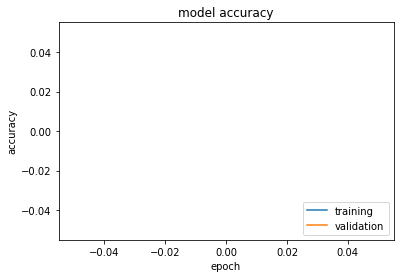

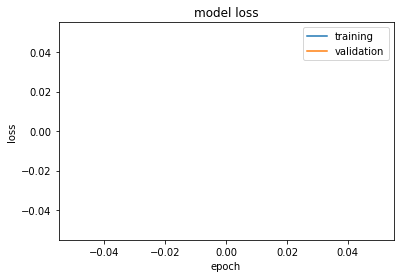

In [29]:
from matplotlib import pyplot as plt
# 学習状況のプロット関数の定義
# 分類精度の履歴をプロット
plt.plot(acc_hist[0])
plt.plot(acc_hist[1])
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['training', 'validation'], loc='lower right')
plt.show()

# 損失関数の履歴をプロット
plt.plot(loss_hist[0])
plt.plot(loss_hist[1])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()


# 疑問点
入力画素数はどこでわかる？

特徴抽出層featuresを2つ用意して、画像と配列それぞれに対して学習すればいいということ？

画像層のグレースケール化は可能？

